Plot the increase in magnetisation relative to the uniform baseline for different Ising influence strategies.

Created on 27/09/20

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib
import pylab
import itertools

In [2]:
init_sign=-1.0

if init_sign==1.0: 
    eval_data = pd.read_csv("Data/Pokec_control_eval_data_positive_start_neg_g.csv").append(pd.read_csv('Data/Pokec_control_eval_data_positive.csv'))
    # filter to even only
    eval_data = eval_data.loc[eval_data['gradient'].isin(list(np.arange(-10.0,12.0,2.0)))]
    
    
elif init_sign==-1.0:
    eval_data = pd.read_csv("Data/Pokec_control_eval_data_negative_beta_8_start_neg_g.csv")
eval_data

,Unnamed: 0,control,magnetisation,mag_se,beta_factor,gradient
0,0,no con,-0.507187,0.000018,8.0,-10.0
1,1,unif,-0.491857,0.000011,8.0,-10.0
2,2,full,-0.450973,0.000006,8.0,-10.0
3,3,block,-0.482753,0.000020,8.0,-10.0
4,4,sv,-0.477499,0.000019,8.0,-10.0
...,...,...,...,...,...,...
1150,2,full,-0.130494,0.000006,8.0,10.0
1151,3,block,-0.158092,0.000013,8.0,10.0
1152,4,sv,-0.155632,0.000011,8.0,10.0
1153,5,nc,-0.166471,0.000008,8.0,10.0


In [3]:
# control_names = ['block','full','nc','sv','snapshot']
control_names = ['nc','sv','snapshot','full','block']

In [4]:
beta_choice = 8.0 #8.0
eval_data = eval_data.loc[eval_data['beta_factor']==beta_choice]
eval_data['Sample_index'] = eval_data.reset_index().reset_index().groupby(by=['control','gradient','beta_factor'])['level_0'].transform(lambda x: x.rank())

pivotted = pd.pivot_table( eval_data , values=['magnetisation'],columns=['control'] ,index=['beta_factor','gradient','Sample_index'],aggfunc={'magnetisation':np.mean} ).reset_index()
pivotted.columns=pivotted.columns.map('_'.join)
for k in control_names :
    pivotted[f"markup_{k}"] = pivotted[f'magnetisation_{k}'] - pivotted['magnetisation_unif']

grouped = pivotted.groupby(['beta_factor_','gradient_']).agg({f'markup_{k}':[np.mean,stats.sem] for k in control_names}).reset_index()
grouped.columns=grouped.columns.map('_'.join)
grouped.head()

,beta_factor__,gradient__,markup_nc_mean,markup_nc_sem,markup_sv_mean,markup_sv_sem,markup_snapshot_mean,markup_snapshot_sem,markup_full_mean,markup_full_sem,markup_block_mean,markup_block_sem
0,8.0,-10.0,-0.021346,0.001390,0.014433,0.001523,0.014101,0.001356,0.031680,0.001485,0.011856,0.001505
1,8.0,-8.0,-0.022707,0.001606,0.007260,0.001321,0.007011,0.001575,0.025645,0.001524,0.003464,0.001282
2,8.0,-6.0,-0.016696,0.001904,0.007085,0.001418,0.008251,0.001070,0.025749,0.001302,-0.000886,0.001841
3,8.0,-4.0,-0.011185,0.001624,0.008238,0.001032,0.008096,0.001336,0.020672,0.000836,0.008816,0.001096
4,8.0,-2.0,-0.004973,0.001769,0.002850,0.001403,0.000553,0.001682,0.014020,0.001741,0.001521,0.001592


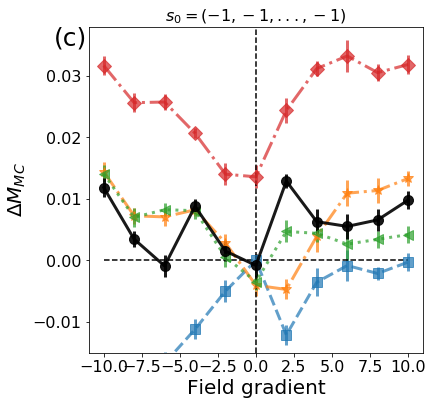

In [5]:
gradient = list(grouped['gradient__'])

# Select colours scheme:
cmap = pylab.cm.get_cmap("tab10", 6)    # PiYG
#hex_codes = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in  range(cmap.N)]
hex_codes  = [matplotlib.colors.rgb2hex(pal) for pal in  sns.color_palette()]
col= itertools.cycle(tuple(hex_codes))
# marker_styles = itertools.cycle(('o','s','*','<',"D","P"))
marker_styles = itertools.cycle(('s','*','<',"D","P"))
line_styles = itertools.cycle(( '--', '-.', ':','-.'))


def name_map(label) :
    """
    Upper case SV and NC.
    
    .title() to other labels
    """
    
    if label=='sv':
        return 'HT'
    elif label=='nc':
        return 'NC'
    
    else :
        return label.title()

fig,ax=plt.subplots(figsize=(6,6))

for con in control_names :
    
    mean_markup = list(grouped[f'markup_{con}_mean'])
    sem_markup = list(grouped[f'markup_{con}_sem'])
    
    #NC control at g=0 should be undefined.
    if con == 'nc' and 0.0 in gradient :
        zero_g_index=gradient.index(0.0)
        mean_markup[zero_g_index]=0.0
        sem_markup[zero_g_index]=0.0
    
    
    if con == 'block' :
        plt.errorbar(gradient,mean_markup,yerr=sem_markup,label=name_map(con)
                 ,mfc=f'k',mec=f'k',
                 color=f'k',
                 marker=f'o',
                linestyle=f'-',alpha=0.9,markersize=10,lw=3.0)
    else :
        col_current=next(col)
        plt.errorbar(gradient,mean_markup,yerr=sem_markup,label=name_map(con)
                     ,mfc=f'{col_current}',mec=f'{col_current}',
                     color=f'{col_current}',
                     marker=f'{next(marker_styles)}',
                    linestyle=f'{next(line_styles)}',alpha=0.7,markersize=10,lw=3.0)

plt.plot([-10,10],[0,0],'k--')

plt.xlabel("Field gradient",fontsize=20)
plt.ylabel("$\Delta M_{MC}$",fontsize=20 )
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.legend(fontsize=14,ncol=2,loc='upper left')

if init_sign==1.0 :
    ax.legend(fontsize=14,ncol=2,loc='lower right').set_zorder(0)

#plt.xlim(-11,11)
#plt.xlim(-1,1)
#plt.xlim(-1,19)
plt.ylim(-0.015,0.038)
#plt.ylim(-0.015,0.017)
plt.plot([0,0],[-0.015,0.038],'k--')


if init_sign==-1.0:
    plt.text(-13.3,0.035,'(c)',fontsize=25)
    plt.title("$s_0=(-1,-1,...,-1)$",fontsize=16)
elif init_sign==1.0:
    plt.text(-13.3,0.035,'(d)',fontsize=25)
    plt.title("$s_0=(+1,+1,...,+1)$",fontsize=16)

plt.savefig(f"Plots/Pokec_markup_as_grad_beta_{beta_choice}_{init_sign}".replace('.','-') + ".jpg",bbox_inches='tight')

In [6]:
single_gradient=eval_data.loc[eval_data['gradient']==0]
single_gradient

,Unnamed: 0,control,magnetisation,mag_se,beta_factor,gradient,Sample_index
525,0,no con,-0.668322,0.000014,8.0,0.0,1
526,1,unif,-0.649866,0.000013,8.0,0.0,1
527,2,full,-0.636021,0.000012,8.0,0.0,1
528,3,block,-0.645938,0.000014,8.0,0.0,1
529,4,sv,-0.654819,0.000008,8.0,0.0,1
...,...,...,...,...,...,...,...
625,2,full,-0.631046,0.000008,8.0,0.0,15
626,3,block,-0.647527,0.000018,8.0,0.0,15
627,4,sv,-0.655126,0.000014,8.0,0.0,15
628,5,nc,-0.002793,0.000026,8.0,0.0,15


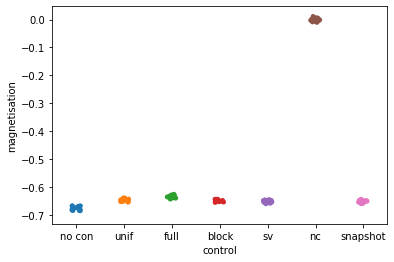

In [7]:
sns.stripplot(data=single_gradient,x='control',y='magnetisation')

In [8]:
np.arange(12.0,19.0,1.0)

array([12., 13., 14., 15., 16., 17., 18.])

## Fraction of full-mf markup

(array([-12.5, -10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,   7.5,
         10. ,  12.5]), <a list of 11 Text xticklabel objects>)

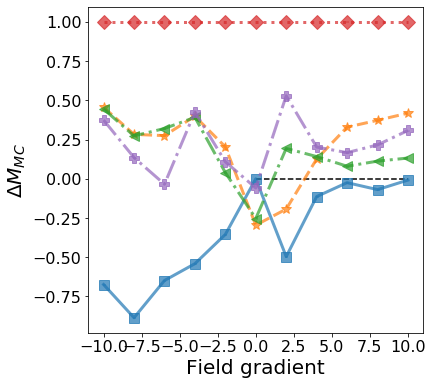

In [9]:
gradient = list(grouped['gradient__'])

# Select colours scheme:
cmap = pylab.cm.get_cmap("tab10", 6)    # PiYG
#hex_codes = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in  range(cmap.N)]
hex_codes  = [matplotlib.colors.rgb2hex(pal) for pal in  sns.color_palette()]
col= itertools.cycle(tuple(hex_codes))
# marker_styles = itertools.cycle(('o','s','*','<',"D","P"))
marker_styles = itertools.cycle(('s','*','<',"D","P"))
line_styles = itertools.cycle(('-', '--', '-.', ':','-.'))


def name_map(label) :
    """
    Upper case SV and NC.
    
    .title() to other labels
    """
    if len(label) < 3 :
        return label.upper()
    else :
        return label.title()

fig,ax=plt.subplots(figsize=(6,6))

for con in control_names :
    
    mean_markup = list(grouped[f'markup_{con}_mean'])
    sem_markup = list(grouped[f'markup_{con}_sem'])
    
    mf_full_markup = list(grouped[f'markup_full_mean'])
    
    mean_markup=[i/j for i,j in zip(mean_markup,mf_full_markup)]
    
    #NC control at g=0 should be undefined.
    if con == 'nc' and 0.0 in gradient :
        zero_g_index=gradient.index(0.0)
        mean_markup[zero_g_index]=0.0
        sem_markup[zero_g_index]=0.0
    
    
    col_current=next(col)
    plt.errorbar(gradient,mean_markup,yerr=sem_markup,label=name_map(con)
                 ,mfc=f'{col_current}',mec=f'{col_current}',
                 color=f'{col_current}',
                 marker=f'{next(marker_styles)}',
                linestyle=f'{next(line_styles)}',alpha=0.7,markersize=10,lw=3.0)

plt.plot([0,10],[0,0],'k--')

plt.xlabel("Field gradient",fontsize=20)
plt.ylabel("$\Delta M_{MC}$",fontsize=20 )
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

## As a fraction above unif

In [10]:
beta_choice = 8.0 #8.0
eval_data = eval_data.loc[eval_data['beta_factor']==beta_choice]
eval_data['Sample_index'] = eval_data.reset_index().reset_index().groupby(by=['control','gradient','beta_factor'])['level_0'].transform(lambda x: x.rank())

pivotted = pd.pivot_table( eval_data , values=['magnetisation'],columns=['control'] ,index=['beta_factor','gradient','Sample_index'],aggfunc={'magnetisation':np.mean} ).reset_index()
pivotted.columns=pivotted.columns.map('_'.join)
for k in control_names :
    pivotted[f"markup_{k}"] = (pivotted[f'magnetisation_{k}'] - pivotted['magnetisation_unif'])/abs(pivotted['magnetisation_unif'])

grouped = pivotted.groupby(['beta_factor_','gradient_']).agg({f'markup_{k}':[np.mean,stats.sem] for k in control_names}).reset_index()
grouped.columns=grouped.columns.map('_'.join)
grouped.head()

,beta_factor__,gradient__,markup_nc_mean,markup_nc_sem,markup_sv_mean,markup_sv_sem,markup_snapshot_mean,markup_snapshot_sem,markup_full_mean,markup_full_sem,markup_block_mean,markup_block_sem
0,8.0,-10.0,-0.043482,0.002893,0.029322,0.003068,0.028636,0.002736,0.064398,0.002950,0.024058,0.003026
1,8.0,-8.0,-0.039970,0.002879,0.012715,0.002311,0.012269,0.002754,0.045027,0.002612,0.006047,0.002250
2,8.0,-6.0,-0.026094,0.003017,0.011009,0.002191,0.012833,0.001648,0.040112,0.001975,-0.001427,0.002885
3,8.0,-4.0,-0.016106,0.002344,0.011843,0.001478,0.011625,0.001912,0.029732,0.001191,0.012669,0.001569
4,8.0,-2.0,-0.007049,0.002501,0.003989,0.001967,0.000747,0.002364,0.019700,0.002425,0.002105,0.002237


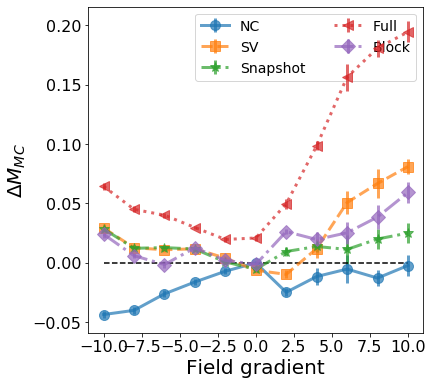

In [11]:
gradient = list(grouped['gradient__'])

# Select colours scheme:
cmap = pylab.cm.get_cmap("tab10", 6)    # PiYG
#hex_codes = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in  range(cmap.N)]
hex_codes  = [matplotlib.colors.rgb2hex(pal) for pal in  sns.color_palette()]
col= itertools.cycle(tuple(hex_codes))
marker_styles = itertools.cycle(('o','s','*','<',"D","P"))
line_styles = itertools.cycle(('-', '--', '-.', ':','-.'))


def name_map(label) :
    """
    Upper case SV and NC.
    
    .title() to other labels
    """
    if len(label) < 3 :
        return label.upper()
    else :
        return label.title()

fig,ax=plt.subplots(figsize=(6,6))

for con in control_names :
    
    mean_markup = list(grouped[f'markup_{con}_mean'])
    sem_markup = list(grouped[f'markup_{con}_sem'])
    
    #NC control at g=0 should be undefined.
    if con == 'nc' and 0.0 in gradient :
        zero_g_index=gradient.index(0.0)
        mean_markup[zero_g_index]=0.0
        sem_markup[zero_g_index]=0.0
    
    col_current=next(col)
    plt.errorbar(gradient,mean_markup,yerr=sem_markup,label=name_map(con)
                 ,mfc=f'{col_current}',mec=f'{col_current}',
                 color=f'{col_current}',
                 marker=f'{next(marker_styles)}',
                linestyle=f'{next(line_styles)}',alpha=0.7,markersize=10,lw=3.0)

plt.plot([-10,10],[0,0],'k--')

plt.xlabel("Field gradient",fontsize=20)
plt.ylabel("$\Delta M_{MC}$",fontsize=20 )
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.legend(fontsize=14,ncol=2,loc='upper left')
ax.legend(fontsize=14,ncol=2,loc='upper right').set_zorder(0)
plt.savefig(f"Plots/FractionalPokec_markup_as_grad_beta_{beta_choice}_{init_sign}".replace('.','-') + ".jpg",bbox_inches='tight')